In [3]:
import pandas as pd
!pip install fastparquet
data = pd.read_parquet("Flight Summary - North Atlantic - 2019.pq")

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: sqlalchemy-mate 1.4.28.3 has a non-standard dependency specifier sqlalchemy>=1.4.1<2.0.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of sqlalchemy-mate or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [4]:
data.head()

,ICAO Aircraft type designator,First known waypoint time (UTC),Last known waypoint time (UTC),Direction,Total flight dist (km),Total fuel burn (kg),Mean overall propulsion efficiency,Aircraft mass mean (kg),Mean nvPM number EI (kg-1),Initial contrail length (km),...,"Ice vol mean radius, Mean (um)","Tau contrail, Mean","Tau cirrus, Mean",RF SW (W m-2),RF LW (W m-2),RF Net (W m-2),Total contrail EF (J),SDR mean (W m-2),RSR mean (W m-2),OLR mean (W m-2)
0,B772,2019-01-01 02:17:49,2019-01-01 05:18:26,E,2633.994219,23991.530999,0.311201,228553.082349,4.920940e+14,1415.515126,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1,B763,2019-01-01 02:19:06,2019-01-01 05:27:55,E,2670.997754,13886.660380,0.325782,150812.984413,1.425808e+15,1701.125144,...,3.716948,0.090483,0.001725,-0.565425,4.231059,3.665634,1.515245e+14,36.862724,15.583469,238.200396
2,B763,2019-01-01 02:21:40,2019-01-01 05:11:34,E,2388.740516,13397.610853,0.304915,150872.338643,1.172578e+15,2388.740516,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
3,B744,2019-01-01 02:16:31,2019-01-01 05:44:38,E,3039.310160,38210.558395,0.317271,311350.241271,5.589923e+14,2216.876721,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
4,B789,2019-01-01 03:15:00,2019-01-01 04:30:15,E,1092.545055,9686.423444,0.282729,212017.428561,8.404441e+14,1092.545055,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000


In [6]:
# We set aside our target variable in this case - 1 if a a persisent contrail has a length > 0 , 0 otherwise

data['PersistentContrail_Formed'] = data['Persistent contrail length (km)'].apply(lambda x: 1 if x > 0 else 0)

In [18]:
# Next we do some feature engineering to deduce temporal characteristics about a flight given the waypoint times

# Convert the string columns to datetime
data['First known waypoint time (UTC)'] = pd.to_datetime(data['First known waypoint time (UTC)'])
data['Last known waypoint time (UTC)'] = pd.to_datetime(data['Last known waypoint time (UTC)'])

# Compute flight duration between waypoints, Time of Day and Month
data['Flight Duration'] = (data['Last known waypoint time (UTC)'] - data['First known waypoint time (UTC)']).dt.total_seconds()
data['Time of Day'] = data['First known waypoint time (UTC)'].dt.hour
data['Month'] = data['First known waypoint time (UTC)'].dt.month

With our list of features in hand - we need to understand which of them are most imporant in understanding our target variable - in this case, persistent contrail formation. The correlation matrix we used in our EDA highlights linear relationships but we need to understand the possibilty of nonlinear relationships as well. 

Our input feature space should be a list of features that have the highest linear and/or nonlinear relationships with our data. That will inform us which model is most effective in forecasting our target.

#### Linear Feature Analysis

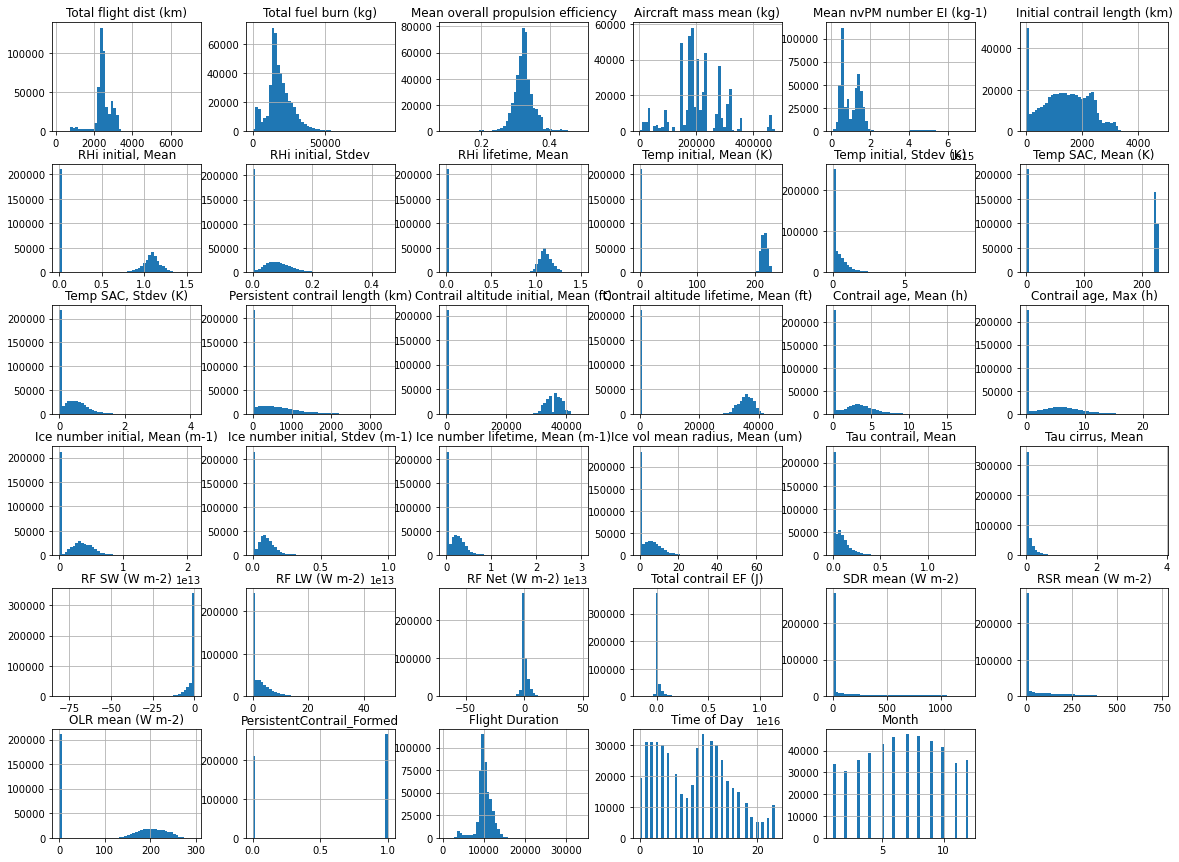

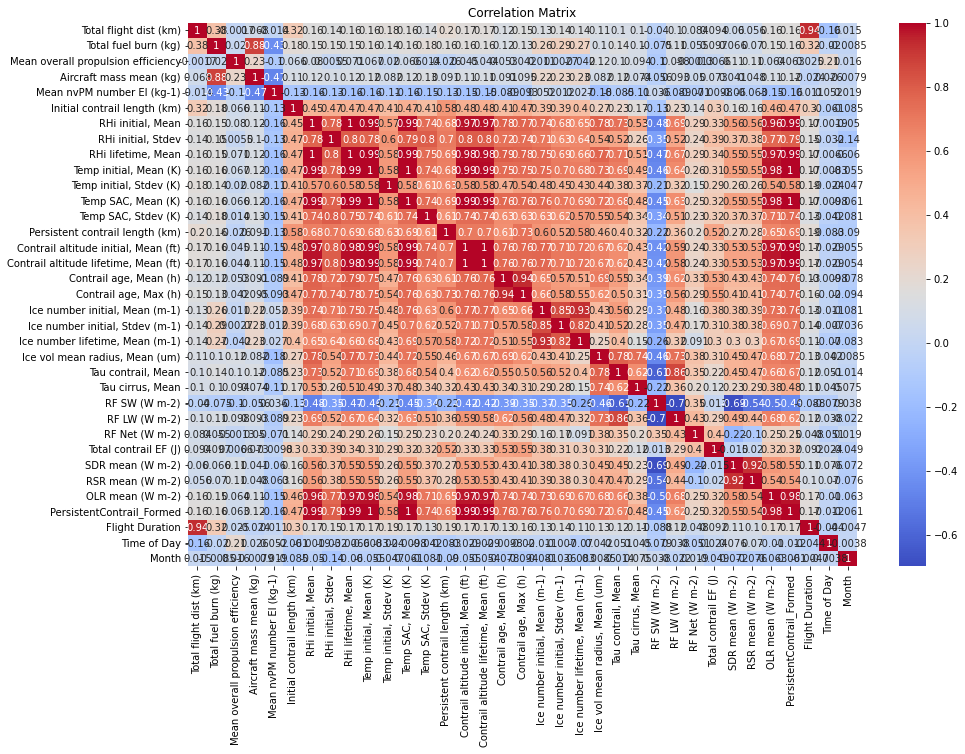

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = data.select_dtypes(include=['float64', 'int64'])
numerical_features.hist(bins=50, figsize=(20,15))

correlation = numerical_features.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

#### Non-linear Feature Analysis

In [37]:
exclude_features = [
    'Persistent contrail length (km)',
    'Contrail altitude initial, Mean (ft)',
    'Contrail altitude lifetime, Mean (ft)',
    'Contrail age, Mean (h)',
    'Contrail age, Max (h)'
]

selected_features = [feat for feat in numerical_features.columns if feat not in exclude_features]

In [39]:
from scipy.stats import spearmanr

spearman_correlations = {}
for feature in selected_features:
    corr, _ = spearmanr(data[feature], data['PersistentContrail_Formed'])
    spearman_correlations[feature] = corr

# Display Spearman correlations sorted by absolute value
sorted_spearman = sorted(spearman_correlations.items(), key=lambda x: abs(x[1]), reverse=True)
for feature, corr in sorted_spearman:
    print(f"{feature}: {corr:.4f}")

PersistentContrail_Formed: 1.0000
OLR mean (W m-2): 0.8995
Tau contrail, Mean: 0.8995
Ice number initial, Stdev (m-1): 0.8995
Temp initial, Stdev (K): 0.8995
Ice number lifetime, Mean (m-1): 0.8995
Ice vol mean radius, Mean (um): 0.8995
RHi initial, Mean: 0.8995
RHi lifetime, Mean: 0.8995
Temp SAC, Stdev (K): 0.8995
Ice number initial, Mean (m-1): 0.8995
Temp initial, Mean (K): 0.8995
RHi initial, Stdev: 0.8995
Temp SAC, Mean (K): 0.8995
RF LW (W m-2): 0.8995
Tau cirrus, Mean: 0.8787
RSR mean (W m-2): 0.8399
SDR mean (W m-2): 0.7847
RF SW (W m-2): -0.7777
Total contrail EF (J): 0.5313
Initial contrail length (km): 0.4697
RF Net (W m-2): 0.3808
Flight Duration: 0.1746
Total fuel burn (kg): 0.1636
Total flight dist (km): 0.1577
Mean nvPM number EI (kg-1): -0.1339
Aircraft mass mean (kg): 0.0884
Mean overall propulsion efficiency: 0.0641
Month: -0.0575
Time of Day: -0.0135


In [ ]:
# Compute mutual information scores
mi_scores = mutual_info_regression(data[selected_features], data['PersistentContrail_Formed'])

# Display mutual information scores
for feature, score in sorted(zip(selected_features, mi_scores), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {score:.4f}")